In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange    

Q1. Pick an image of your liking and reconstruct it using matrix factorization. Choose a suitable value for the rank 𝑟 r. Run Gradient Descent until it converges, plot the reconstructed image alongside the original image. Calculate and report the RMSE and PSNR metrics

In [2]:
cat  = "/home/harshal/ML/es335-24-fall-assignment-2/sample_images/cat.jpg"

if os.path.exists(cat):
    print('cat.jpg exists')
else :
    print('Image does not exists')

cat.jpg exists


In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image(cat)
print(img.shape)
print(torch.tensor(img))


torch.Size([3, 415, 608])
tensor([[[126, 124, 122,  ..., 139, 139, 141],
         [126, 125, 123,  ..., 138, 139, 140],
         [127, 126, 125,  ..., 138, 140, 141],
         ...,
         [106, 106, 119,  ..., 151, 139, 118],
         [120, 106, 110,  ..., 170, 148, 123],
         [119, 116, 118,  ..., 187, 154, 122]],

        [[159, 157, 155,  ..., 159, 159, 160],
         [159, 158, 156,  ..., 158, 158, 159],
         [160, 159, 158,  ..., 158, 158, 159],
         ...,
         [142, 128, 137,  ..., 166, 154, 135],
         [152, 134, 140,  ..., 171, 154, 137],
         [150, 147, 149,  ..., 177, 155, 138]],

        [[ 52,  50,  50,  ...,  44,  44,  45],
         [ 52,  51,  51,  ...,  45,  43,  44],
         [ 55,  54,  53,  ...,  47,  46,  47],
         ...,
         [ 20,   1,   1,  ...,  47,  27,   5],
         [ 29,  11,  10,  ...,  43,  20,   0],
         [ 31,  28,  30,  ...,  45,  19,   5]]], dtype=torch.uint8)


In [4]:
# Make grayscale
img = torch.tensor(img, dtype=torch.float)
img = img.mean(dim=0, keepdim=False)
print(img.shape)

torch.Size([415, 608])


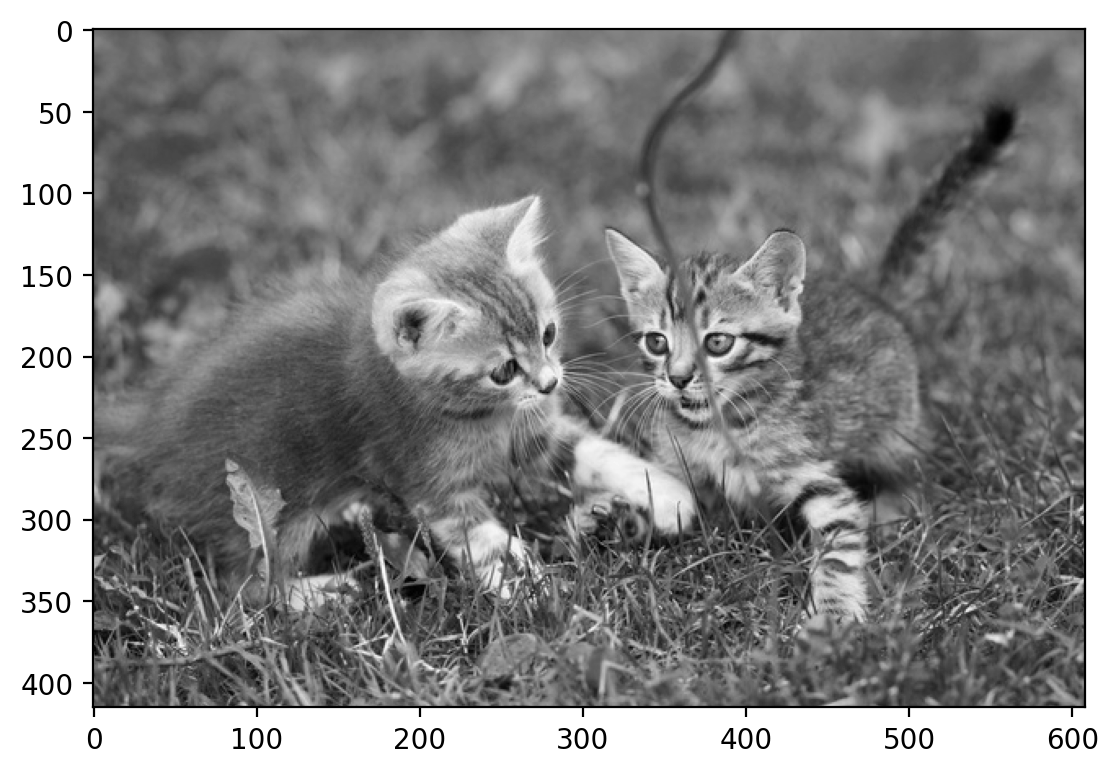

In [5]:
plt.imshow(img, cmap='gray')


In [6]:
crop = torchvision.transforms.functional.crop(img, 100, 150, 300, 300)
crop.shape

torch.Size([300, 300])

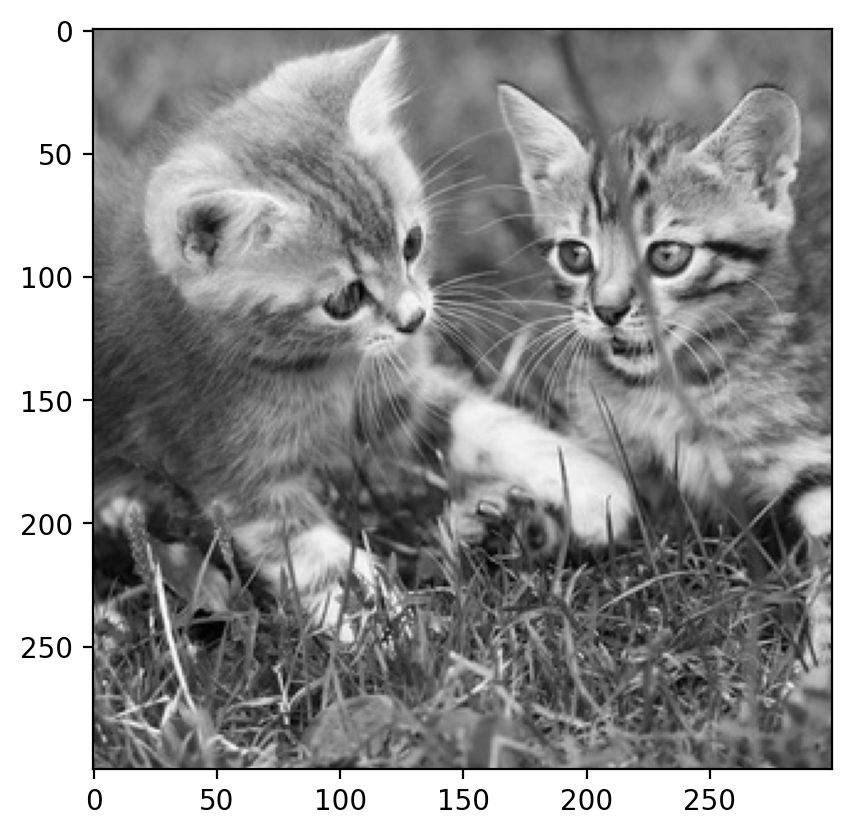

In [7]:
plt.imshow(crop, cmap='gray')


In [8]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(crop.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [9]:
img_scaled = scaler_img.transform(crop.reshape(-1, 1)).reshape(crop.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)
img_scaled


tensor([[0.4961, 0.4882, 0.4803,  ..., 0.4580, 0.4646, 0.4606],
        [0.4856, 0.4738, 0.4764,  ..., 0.4501, 0.4488, 0.4462],
        [0.4829, 0.4751, 0.4764,  ..., 0.4383, 0.4344, 0.4344],
        ...,
        [0.3255, 0.3976, 0.3596,  ..., 0.3373, 0.3255, 0.3556],
        [0.2625, 0.4278, 0.4724,  ..., 0.3307, 0.3202, 0.3635],
        [0.3911, 0.4344, 0.3990,  ..., 0.3373, 0.3793, 0.3990]],
       dtype=torch.float64)

In [10]:
img_scaled = img_scaled.to(device)
print(img_scaled.shape)
img_scaled

torch.Size([300, 300])


tensor([[0.4961, 0.4882, 0.4803,  ..., 0.4580, 0.4646, 0.4606],
        [0.4856, 0.4738, 0.4764,  ..., 0.4501, 0.4488, 0.4462],
        [0.4829, 0.4751, 0.4764,  ..., 0.4383, 0.4344, 0.4344],
        ...,
        [0.3255, 0.3976, 0.3596,  ..., 0.3373, 0.3255, 0.3556],
        [0.2625, 0.4278, 0.4724,  ..., 0.3307, 0.3202, 0.3635],
        [0.3911, 0.4344, 0.3990,  ..., 0.3373, 0.3793, 0.3990]],
       device='cuda:0', dtype=torch.float64)

In [11]:
#Matrix Factorization
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n = 300
r = 3
A = img_scaled
W = torch.randn(n, r, requires_grad=True, device=device)
H = torch.randn(r, n, requires_grad=True, device=device)

# Compute the loss
with torch.no_grad():
    loss = torch.norm(torch.mm(W, H) - A)
    print(loss)


tensor(535.0060, device='cuda:0', dtype=torch.float64)


In [12]:
mask = ~torch.isnan(A)
mask

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')

In [13]:
def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix A into W and H
    A: input matrix of size (n_users, n_movies)
    k: number of latent features
    
    Returns W and H
    W: matrix of size (n_users, k)
    H: matrix of size (k, n_movies)
    """
    A = A.to(device)
    # Randomly initialize W and H
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    
    # Train the model
    for i in range(1000):
        # Compute the loss
        loss = torch.norm(torch.mm(W, H) - A)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss

In [14]:
for k in [1, 2, 3, 4, 5, 6, 9]:
    W, H, loss = factorize(A, k, device=device)
    print(k, loss.item())

1 51.50185361156448
2 46.329000422128615
3 44.29920331228274
4 43.21630322139294
5 41.610173244944825
6 38.762413029751194
9 37.84487130496964


In [15]:
W, H, loss = factorize(A, 30, device=device)
print(loss.item())


26.444694135726348


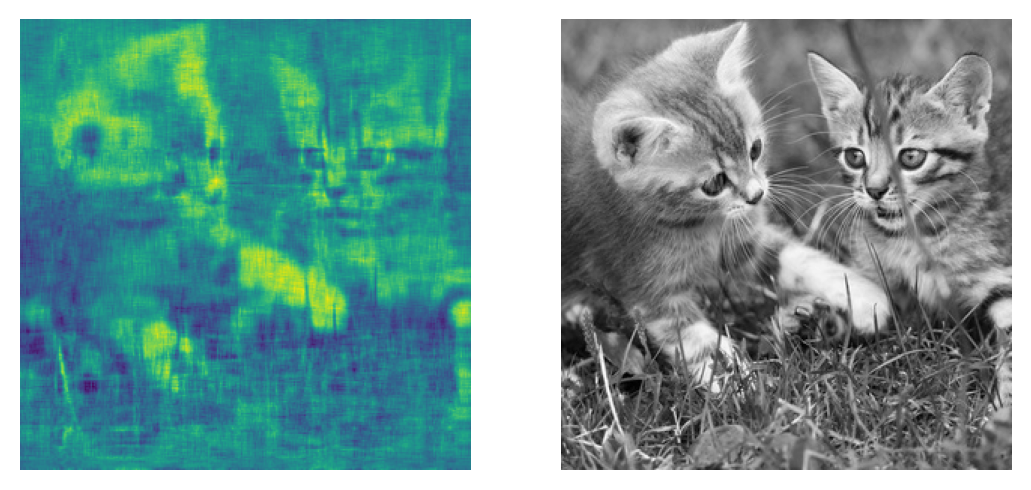

In [16]:
re_img = torch.mm(W,H).cpu().detach().numpy()
plt.subplot(1, 2, 1)  
plt.imshow(re_img)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(crop, cmap='gray')
plt.axis('off')
plt.show()


In [17]:
re_img

array([[0.40236372, 0.40684795, 0.4045003 , ..., 0.3740673 , 0.3760493 ,
        0.36843795],
       [0.44026735, 0.44656107, 0.4344072 , ..., 0.41615385, 0.43065608,
        0.41696507],
       [0.44584653, 0.45326844, 0.3943875 , ..., 0.38874358, 0.38729092,
        0.36936316],
       ...,
       [0.3090671 , 0.31924012, 0.3448732 , ..., 0.3644242 , 0.3620214 ,
        0.37793732],
       [0.2769755 , 0.32417822, 0.30015346, ..., 0.35868514, 0.36766967,
        0.39029908],
       [0.27790734, 0.35905385, 0.3023638 , ..., 0.3201649 , 0.35129985,
        0.35940465]], dtype=float32)

In [18]:
def calculate_rmse(original_img, reconstructed_img):
    # Convert images to numpy arrays for RMSE calculation

    original_img = original_img.cpu().numpy()
    reconstructed_img = reconstructed_img

    # Calculate RMSE
    mse = np.mean((original_img - reconstructed_img) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def calculate_psnr(original_img, reconstructed_img):

    original_img = original_img.cpu().numpy()
    reconstructed_img = reconstructed_img

    # Calculate MSE
    mse = np.mean((original_img - reconstructed_img) ** 2)

    # Calculate PSNR
    if mse == 0:
        return float('inf')  # PSNR is infinite if MSE is zero
    max_pixel = 1.0  #images are normalized to [0, 1]
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr




In [19]:
rmse = calculate_rmse(A,re_img)
psnr = calculate_psnr(A,re_img)

print('rmse :',rmse)
print('psnr :',psnr)

rmse : 0.0881288340308651
psnr : 21.09763951354787


Q2.Consider a case where 900 pixels (30x30) are randomly missing from an image. Reconstruct the image using matrix factorization, plot the reconstructed image, and calculate the RMSE and PSNR metrics. Next, reconstruct the same image with the missing pixels using Random Fourier Features (RFF) and Linear Regression. Compute the RMSE and PSNR for both methods, and compare the results to see which performs better.[3 Marks]

In [20]:
# Mask the image with NaN values 
def mask_image(img, prop):
    img_copy = img.clone()
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy, mask

(tensor([[126.3333, 124.3333, 122.3333,  ..., 116.6667, 118.3333, 117.3333],
        [123.6667, 120.6667, 121.3333,  ..., 114.6667, 114.3333, 113.6667],
        [123.0000, 121.0000, 121.3333,  ..., 111.6667, 110.6667, 110.6667],
        ...,
        [ 83.0000, 101.3333,  91.6667,  ...,  86.0000,  83.0000,  90.6667],
        [ 67.0000, 109.0000, 120.3333,  ...,  84.3333,  81.6667,  92.6667],
        [ 99.6667, 110.6667, 101.6667,  ...,  86.0000,  96.6667, 101.6667]]), tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]]))
tensor(890)


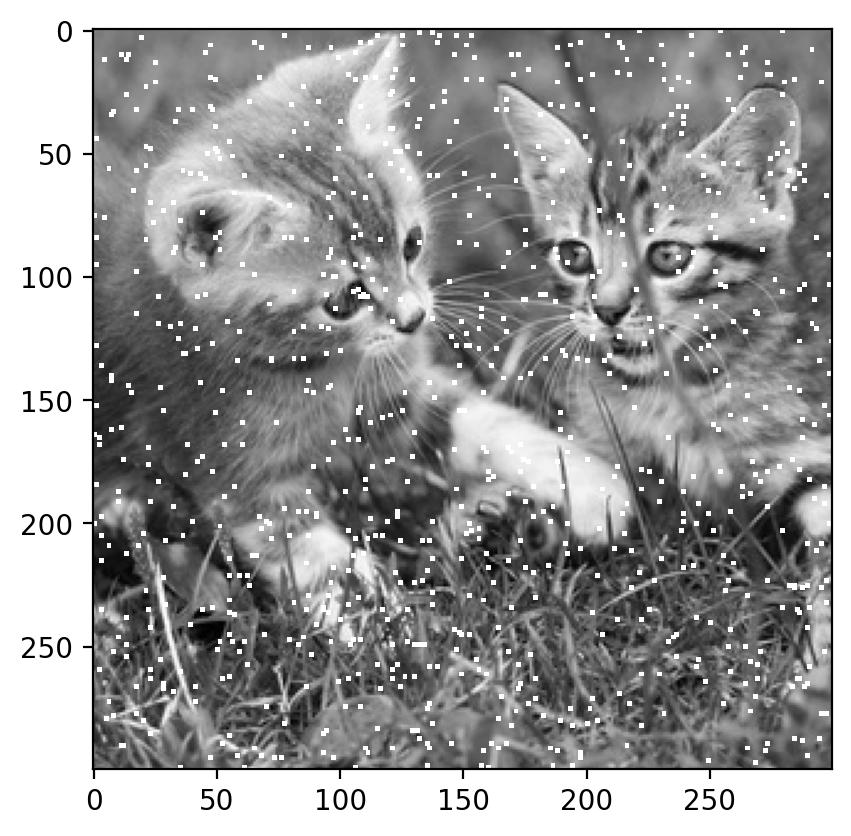

In [21]:

masked_img = mask_image(crop,0.01)
print(masked_img)
print(masked_img[1].sum())
plt.imshow(masked_img[0],cmap='gray')

In [22]:
#preprocessing cropped image_with_nan
from sklearn import preprocessing

copy_scaler_img = preprocessing.MinMaxScaler().fit(masked_img[0].reshape(-1, 1))
copy_scaler_img

MinMaxScaler()

In [23]:
copy_image = copy_scaler_img.transform(masked_img[0].reshape(-1, 1)).reshape(masked_img[0].shape)
copy_image.shape

copy_image = torch.tensor(copy_image)
copy_image

tensor([[0.4961, 0.4882, 0.4803,  ..., 0.4580, 0.4646, 0.4606],
        [0.4856, 0.4738, 0.4764,  ..., 0.4501, 0.4488, 0.4462],
        [0.4829, 0.4751, 0.4764,  ..., 0.4383, 0.4344, 0.4344],
        ...,
        [0.3255, 0.3976, 0.3596,  ..., 0.3373, 0.3255, 0.3556],
        [0.2625, 0.4278, 0.4724,  ..., 0.3307, 0.3202, 0.3635],
        [0.3911, 0.4344, 0.3990,  ..., 0.3373, 0.3793, 0.3990]],
       dtype=torch.float64)

In [24]:
copy_image = copy_image.to(device)
print(copy_image.shape)
copy_image

torch.Size([300, 300])


tensor([[0.4961, 0.4882, 0.4803,  ..., 0.4580, 0.4646, 0.4606],
        [0.4856, 0.4738, 0.4764,  ..., 0.4501, 0.4488, 0.4462],
        [0.4829, 0.4751, 0.4764,  ..., 0.4383, 0.4344, 0.4344],
        ...,
        [0.3255, 0.3976, 0.3596,  ..., 0.3373, 0.3255, 0.3556],
        [0.2625, 0.4278, 0.4724,  ..., 0.3307, 0.3202, 0.3635],
        [0.3911, 0.4344, 0.3990,  ..., 0.3373, 0.3793, 0.3990]],
       device='cuda:0', dtype=torch.float64)

In [25]:
#Matrix factorization function for missing values 

def factorize_wih_NaN(A, k, device=torch.device("cpu")):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(1000):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss


In [26]:
W, H, loss = factorize_wih_NaN(copy_image, 30, device=device)
loss

tensor(26.5520, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)

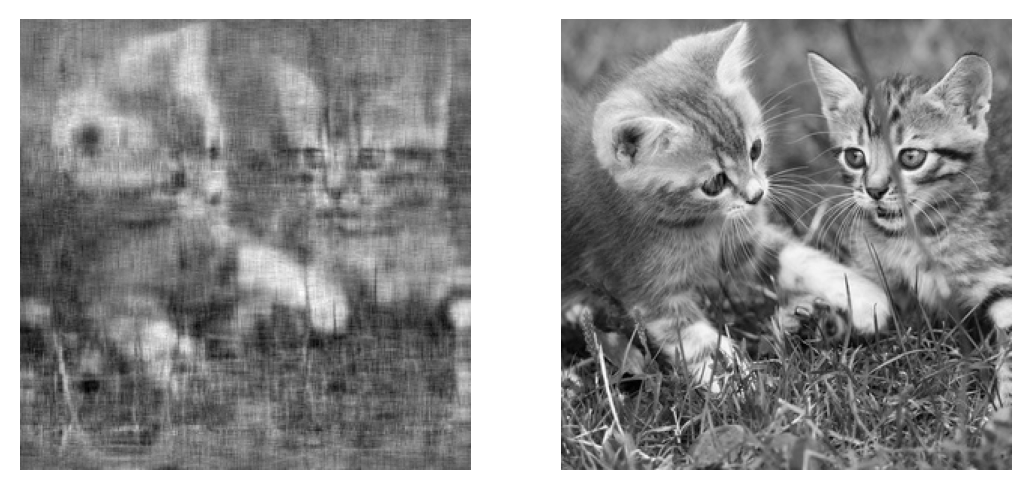

In [27]:
re_img_with_NaN = torch.mm(W, H).cpu().detach().numpy()

plt.subplot(1, 2, 1)  
plt.imshow(re_img_with_NaN,cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(crop, cmap='gray')
plt.axis('off')
plt.show()

In [28]:
#calulating rmse and psnr 
rmse = calculate_rmse(img_scaled,re_img_with_NaN)
psnr = calculate_psnr(img_scaled,re_img_with_NaN)

print('rmse :',rmse)
print('psnr :',psnr)

rmse : 0.08911521240555419
psnr : 21.00096306856406


Reconstructing Image with missing values with RFF

In [29]:
# Get the dimensions of the image tensor
height, width = copy_image.shape
print( height, width)

300 300


In [30]:
def create_coordinate_map(img):
    # img is assumed to be of shape (height, width) for grayscale image
    height, width = img.shape

    # Create a 2D grid of (x, y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, 1), as there's only one channel in grayscale
    Y = img.reshape(-1, 1).float()

    return X, Y


In [31]:
cat_X, cat_Y = create_coordinate_map(crop)
cat_X.shape, cat_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 1]))

In [32]:

# Assuming cat_X is on the GPU, move it to CPU for scaling with sklearn
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(cat_X.cpu())

# Scale the X coordinates (2D coordinates for the image)
cat_X_scaled = scaler_X.transform(cat_X.cpu())

# Convert the scaled X back to a PyTorch tensor and move it to GPU
cat_X_scaled = torch.tensor(cat_X_scaled).to(device)

# Set the tensor to dtype float32
cat_X_scaled = cat_X_scaled.float()

cat_X_scaled  # View the result


tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9933],
        [-1.0000, -0.9866],
        ...,
        [ 1.0000,  0.9866],
        [ 1.0000,  0.9933],
        [ 1.0000,  1.0000]], device='cuda:0')

In [33]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)
    

In [34]:
net = LinearModel(2, 1)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

In [35]:
output = net(cat_X_scaled)
print(output.shape)

torch.Size([90000, 1])


In [36]:
def train(net, lr, X, Y, epochs, device, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 1 or 3) depending on grayscale or RGB
    epochs: int, number of training iterations
    device: torch.device, the device to use ('cpu' or 'cuda')
    verbose: bool, whether to print loss at intervals
    """

    # Move the model to the specified device
    net.to(device)
    
    # Move X and Y to the same device
    X = X.to(device)
    Y = Y.to(device)

    criterion = nn.MSELoss()  # Initialize the loss function (Mean Squared Error)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)  # Initialize optimizer (Adam)
    
    for epoch in range(epochs):
        optimizer.zero_grad()  # Zero the gradients
        outputs = net(X)  # Forward pass

        loss = criterion(outputs, Y)  # Compute the loss
        loss.backward()  # Backward pass (compute gradients)
        optimizer.step()  # Update model parameters

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs} loss: {loss.item():.6f}")  # Print the loss every 100 epochs

    print(f"Final loss after {epochs} epochs: {loss.item():.6f}")
    return loss.item()


In [37]:
import torch
import numpy as np
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    """
    Create Random Fourier Features (RFF) for the input X, handling missing values.

    X: torch.Tensor of shape (num_samples, num_features)
    num_features: int, number of random Fourier features to generate
    sigma: float, bandwidth parameter for the RBF kernel
    """
    
    # Convert tensor to NumPy and handle missing values
    X_np = X.detach().cpu().numpy()
    

    nan_mask = np.isnan(X_np)
    if np.any(nan_mask):
        col_means = np.nanmean(X_np, axis=0)
        X_np[nan_mask] = np.take(col_means, np.where(nan_mask)[1])
    
    # Initialize RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1 / (2 * sigma**2))
    
    X_rff = rff.fit_transform(X_np)
    
    return torch.tensor(X_rff, dtype=torch.float32).to(device)




In [38]:
# Generate RFF features
X_rff = create_rff_features(cat_X_scaled, 3750, 0.008)
print(X_rff.shape) 


torch.Size([90000, 3750])


In [39]:
# Initialize the model
net = LinearModel(X_rff.shape[1], 1)  
net.to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model
final_loss = train(net, 0.6, X_rff, cat_Y, 1000,device=device)

# Print final loss
print(f"Final loss after training: {final_loss:.6f}")


Epoch 0/1000 loss: 17058.058594
Epoch 100/1000 loss: 6433.877441
Epoch 200/1000 loss: 2879.677246
Epoch 300/1000 loss: 2035.128418
Epoch 400/1000 loss: 1871.945068
Epoch 500/1000 loss: 1827.826172
Epoch 600/1000 loss: 1805.300659
Epoch 700/1000 loss: 1790.281738
Epoch 800/1000 loss: 1779.547729
Epoch 900/1000 loss: 1771.690308
Final loss after 1000 epochs: 1765.932617
Final loss after training: 1765.932617


In [40]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    Plot the reconstructed and original grayscale images side by side.

    net: torch.nn.Module - The trained model.
    X: torch.Tensor of shape (num_samples, 2) - The input features.
    original_img: torch.Tensor of shape (height, width) or (1, height, width) - The original grayscale image.
    title: str - Title of the plot.
    """
    # Handle both 2D and 3D (with channel) grayscale images
    if original_img.ndimension() == 3:  
        original_img = original_img.squeeze(0)
    
    height, width = original_img.shape

    # Set the model to evaluation mode and get the reconstructed output
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width) 

    # Create a figure for plotting
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    # Plot the reconstructed image
    ax0 = plt.subplot(gs[0])
    ax0.imshow(outputs.cpu(), cmap='gray') 
    ax0.set_title("Reconstructed Image")

    # Plot the original grayscale image
    ax1 = plt.subplot(gs[1])
    ax1.imshow(original_img.cpu(), cmap='gray')  
    ax1.set_title("Original Image")

    # Turn off axis labels for both images
    for a in [ax0, ax1]:
        a.axis("off")

    # Set the title for the entire figure
    fig.suptitle(title, y=0.9)
    plt.tight_layout()

    # Show the plot
    plt.show()


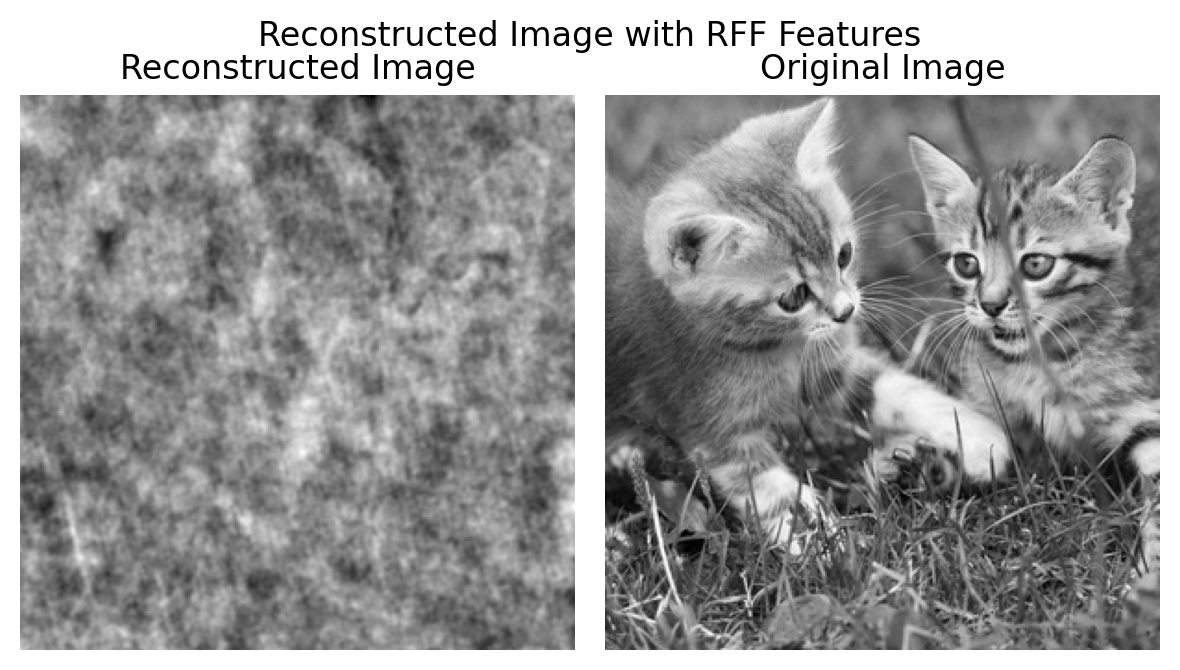

In [41]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

In [42]:
height, width = crop.shape

# Set the model to evaluation mode and get the reconstructed output
net.eval()
with torch.no_grad():
    outputs = net(X_rff)
    outputs = outputs.reshape(height, width)  

print(outputs)



tensor([[134.5188, 128.2299, 126.6672,  ..., 159.3842, 167.9944, 183.2558],
        [135.2043, 127.0471, 125.2477,  ..., 158.2346, 170.5159, 187.8478],
        [135.9434, 129.7114, 130.7177,  ..., 156.3019, 171.2401, 187.7541],
        ...,
        [167.6520, 152.5542, 149.5755,  ..., 103.8463,  93.5512,  85.7020],
        [172.6117, 158.6966, 157.7998,  ..., 110.4969,  98.0845,  86.6129],
        [180.4930, 167.8448, 162.8842,  ..., 121.3739, 108.4705,  96.3958]],
       device='cuda:0')


In [43]:
#reshape image

from sklearn import preprocessing
outputs = outputs.cpu()
rec_img = preprocessing.MinMaxScaler().fit(outputs.reshape(-1, 1))
rec_img

copy_image2 = rec_img.transform(outputs.reshape(-1, 1)).reshape(outputs.shape)
copy_image2.shape

copy_image2 = torch.tensor(copy_image2)
copy_image2

copy_image2 = copy_image2.to(device)
copy_image2 = copy_image2.cpu().detach().numpy()

In [44]:
# Calculate RMSE and PSNR
rmse = calculate_rmse(img_scaled, copy_image2)
psnr = calculate_psnr(img_scaled, copy_image2)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr:.2f} dB")

Root Mean Squared Error (RMSE): 0.1751
Peak Signal-to-Noise Ratio (PSNR): 15.14 dB
